In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


In [ ]:
import os

num_skipped = 0
for folder_name in ("neutrophil", "eosinophil"):
    folder_path = os.path.join("D:\\Image-intern\\blood_image\\traine", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            os.remove(fpath)

print("Deleted %d images" % num_skipped)


Deleted 0 images


In [ ]:
image_size = (180, 180)
batch_size = 19

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "D:\\Image-intern\\blood_image\\traine",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "D:\\Image-intern\\blood_image\\teste",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)


Found 38 files belonging to 2 classes.
Using 31 files for training.
Found 61 files belonging to 2 classes.
Using 12 files for validation.


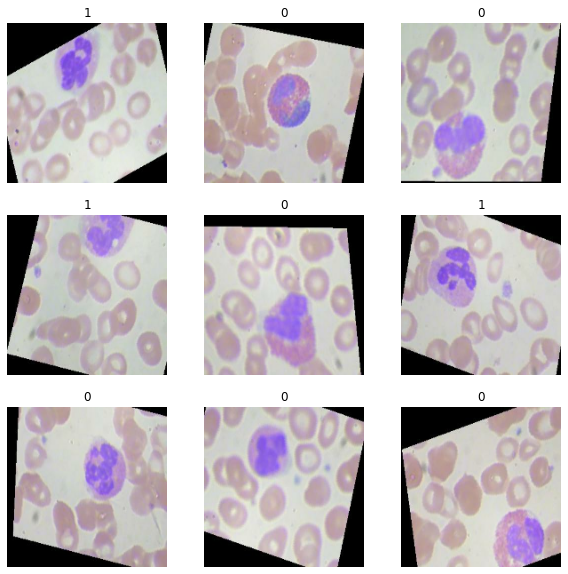

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")


In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)


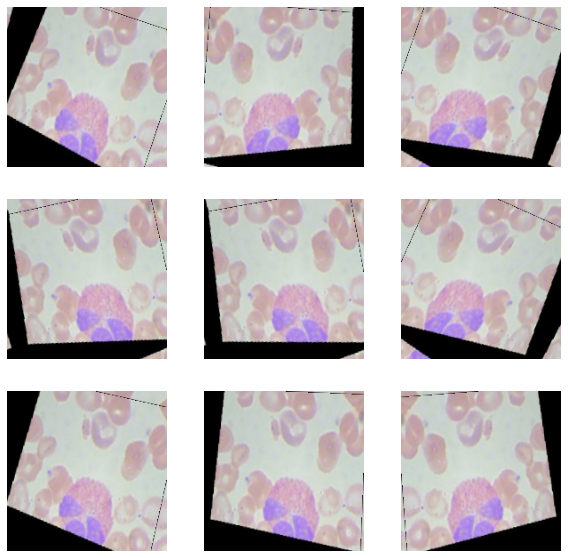

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")


In [ ]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)


In [ ]:

def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    x = data_augmentation(inputs)
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x
    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)
        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])
        previous_block_activation = x

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)



('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [ ]:
epochs = 50

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)


Epoch 1/50
2/2 [==============================] - 4s 2s/step - loss: 0.7339 - accuracy: 0.5161 - val_loss: 0.7016 - val_accuracy: 0.1667
Epoch 2/50
2/2 [==============================] - 3s 2s/step - loss: 0.5916 - accuracy: 0.5806 - val_loss: 0.7071 - val_accuracy: 0.1667
Epoch 3/50
2/2 [==============================] - 3s 1s/step - loss: 0.5329 - accuracy: 0.6774 - val_loss: 0.7066 - val_accuracy: 0.1667
Epoch 4/50
2/2 [==============================] - 3s 1s/step - loss: 0.4593 - accuracy: 0.7742 - val_loss: 0.7036 - val_accuracy: 0.1667
Epoch 5/50
2/2 [==============================] - 3s 1s/step - loss: 0.2173 - accuracy: 0.9355 - val_loss: 0.6987 - val_accuracy: 0.1667
Epoch 6/50
2/2 [==============================] - 3s 1s/step - loss: 0.3089 - accuracy: 0.8710 - val_loss: 0.6965 - val_accuracy: 0.1667
Epoch 7/50
2/2 [==============================] - 3s 1s/step - loss: 0.2538 - accuracy: 0.8710 - val_loss: 0.6957 - val_accuracy: 0.1667
Epoch 8/50
2/2 [=========================

In [ ]:
img = keras.preprocessing.image.load_img(
    "D:\\Image-intern\\SPT\\dataset2-master\\dataset2-master\\images\\TRAIN\\EOSINOPHIL\\_7_6084.jpeg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

predictions = model.predict(img_array)
score = predictions[0]
print(
    "This image is %.2f percent neutrophil and %.2f percent eosinphil."
    % (100 * (1 - score), 100 * score)
)


This image is 46.67 percent neutrophil and 53.33 percent eosinphil.


In [ ]:
img1 = keras.preprocessing.image.load_img(
    "D:\\Image-intern\\SPT\\dataset2-master\\dataset2-master\\images\\TRAIN\\NEUTROPHIL\\_15_9335.jpeg", target_size=image_size
)
img_array1 = keras.preprocessing.image.img_to_array(img1)
img_array1 = tf.expand_dims(img_array1, 0)

predictions1 = model.predict(img_array1)
score1 = predictions1[0]
print(
    "This image is %.2f percent neutrophil and %.2f percent eosinphil."
    % (100 * (1 - score1), 100 * score1)
)


This image is 46.90 percent neutrophil and 53.10 percent eosinphil.
